In [12]:
from infer import InferenceHelper
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio
import cv2

In [18]:
def mask(gt_depth, pred, min_depth_eval, max_depth_eval):
    # Uses 1. eigen_crop mask according to Eigen NIPS14'
    #      2. valid prediction mask for predictions (>= predefined min_depth_eval) 
    #         and (<= predefined max_depth_eval)
    # Defaults --min_depth_eval 1e-3 --max_depth_eval 10
    pred[pred < min_depth_eval] = min_depth_eval
    pred[pred > max_depth_eval] = max_depth_eval
    pred[np.isinf(pred)] = max_depth_eval
    pred[np.isnan(pred)] = min_depth_eval
    
    valid_mask = np.logical_and(gt_depth > min_depth_eval, gt_depth < max_depth_eval)
    eval_mask = np.zeros(valid_mask.shape)
    eval_mask[45:471, 41:601] = 1 # eigen_crop
    
    combined_mask = np.logical_and(valid_mask, eval_mask)
    
    return gt_depth[combined_mask], pred[combined_mask]

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)

def metrics(pred, gt_depth, min_depth_eval=1e-3, max_depth_eval=10):

    gt, pred = mask(gt_depth, pred, min_depth_eval, max_depth_eval)
    metrics_dict = compute_errors(gt, pred)
    
    return metrics_dict
    

In [3]:
## initialize AdaBins model (using weights in ./pretrained)
infer_helper = InferenceHelper(dataset='nyu')

Loading base model ()...

Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /tmp/xdg-cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ap-9e82fae8.pth" to /tmp/xdg-cache/torch/hub/checkpoints/tf_efficientnet_b5_ap-9e82fae8.pth


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


In [33]:
image_idx = 4
image_idx_str = '{:05d}'.format(image_idx)
input_path = './../nyuv2-python-toolkit/NYUv2/image/train/'+image_idx_str+'.png'
gt_path = './../nyuv2-python-toolkit/NYUv2/depth/train/'+image_idx_str+'.png'

#### Load ground truth depth maps and images
gt_depth_uint16 = imageio.imread(gt_path)  # any rgb pillow image
gt_depth = np.asarray(gt_depth_uint16/1000)
print('Ground truth: ',type(gt_depth), gt_depth.shape, gt_depth.dtype)
print('  mean depth: ',np.mean(gt_depth))
img = Image.open(input_path)  # any rgb pillow image
img.save('./input_DPT/'+image_idx_str+'.png')


#### AdaBins predictions
# predict depth of a single pillow image
bin_centers, pred_AdaBins_fullDim = infer_helper.predict_pil(img)
pred_AdaBins = pred_AdaBins_fullDim.squeeze()
print('AdaBins prediction: ',type(pred_AdaBins), pred_AdaBins.shape, pred_AdaBins.dtype)
print('  mean depth: ',np.mean(pred_AdaBins))


#### DPT predictions
!cd ./../DPT/ && python run_monodepth.py -t dpt_hybrid_nyu
# pred_DPT_PIL = Image.open('./output_DPT/'+image_idx_str+'.png')
# pred_DPT = np.asarray(pred_DPT_PIL)/1000
pred_DPT_PIL = cv2.imread('./output_DPT/'+image_idx_str+'.png')
pred_DPT = np.asarray(pred_DPT_PIL)[:,:,0]/1000
print('DPT prediction: ',type(pred_DPT), pred_DPT.shape, pred_DPT.dtype)
print('  mean depth: ',np.mean(pred_DPT),' max depth: ',np.max(pred_DPT),' min depth: ',np.min(pred_DPT))
# plt.imshow(pred_DPT)
# plt.show()

Ground truth:  <class 'numpy.ndarray'> (480, 640) float64
  mean depth:  1.88572875
AdaBins prediction:  <class 'numpy.ndarray'> (480, 640) float32
  mean depth:  1.8786132
initialize
/home/siz075/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
device: cpu
start processing
  processing ./../AdaBins/input_DPT/00004.png (1/2)
/home/siz075/.local/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. 

In [23]:
np.mean(pred_DPT[:,:,2])

0.1811794563802083

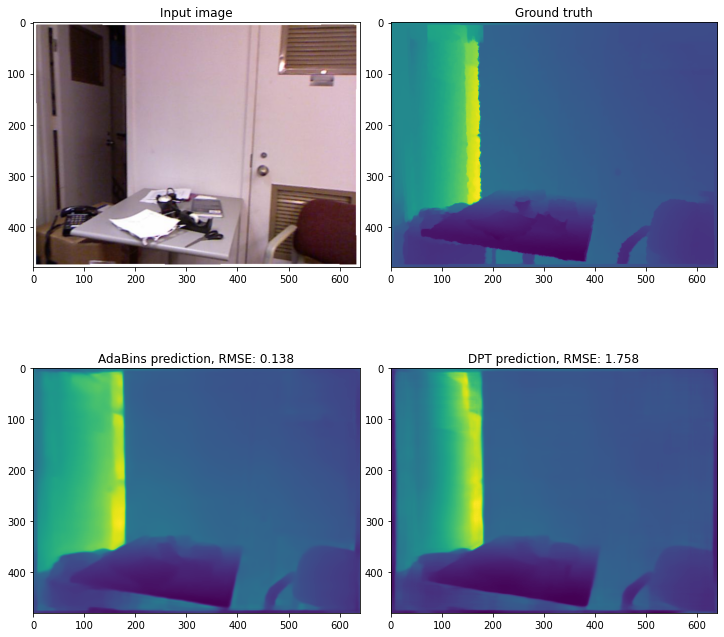

In [30]:
#### metrics
metrics_dict_AdaBins = metrics(pred_AdaBins, gt_depth) # dictionary keys are['a1','a2','a3','abs_rel',
                                                       # 'rmse','log_10','rmse_log','silog','sq_rel']
metrics_dict_DPT = metrics(pred_DPT, gt_depth)
   
    
#### Plots
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(img)
axs[0, 0].set_title('Input image')
axs[0, 1].imshow(gt_depth)
axs[0, 1].set_title('Ground truth')
axs[1, 0].imshow(pred_AdaBins)
axs[1, 0].set_title('AdaBins prediction, RMSE: {:.3f}'.format(metrics_dict_AdaBins['rmse']))
axs[1, 1].imshow(pred_DPT)
axs[1, 1].set_title('DPT prediction, RMSE: {:.3f}'.format(metrics_dict_DPT['rmse']))
fig.tight_layout(pad=0.5)
plt.show()